In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

# Hypothesis
The wine price has a certain relation to the review score.

# Setup data

Read in data and replace unknown values with NA

In [2]:
wine_data_path = "../data/winemag-data-130k-v2.csv" 

missing_values = ["n/a", "na", "--", "false"]
raw_wine_data = pd.read_csv(wine_data_path, na_values = missing_values)

Select columns relevant for our hypothesis and remove the values with NA

In [3]:
filtered_wine_data = raw_wine_data[['points', 'price']]
clean_wine_data = filtered_wine_data.dropna()

Remove rows with huge price outliers

In [4]:
clean_wine_data = clean_wine_data.loc[clean_wine_data['price'] < 1000]
mean = clean_wine_data.price.mean()
std = clean_wine_data.price.std()

filtered_data = clean_wine_data[np.abs(clean_wine_data.price - mean) <= (20*std)]

# Correlation

Correlation between points and the description length seems to be a small positive correlation.

In [5]:
clean_wine_data.corr()

,points,price
points,1.000000,0.466528
price,0.466528,1.000000


# Price versus grouped points

Group the panda dataframe by description length and calculate mean and standard deviation of every group.

In [6]:
price_means = filtered_data['price'].groupby(filtered_data['points']).mean()
points_means = filtered_data['points'].groupby(filtered_data['price']).mean()

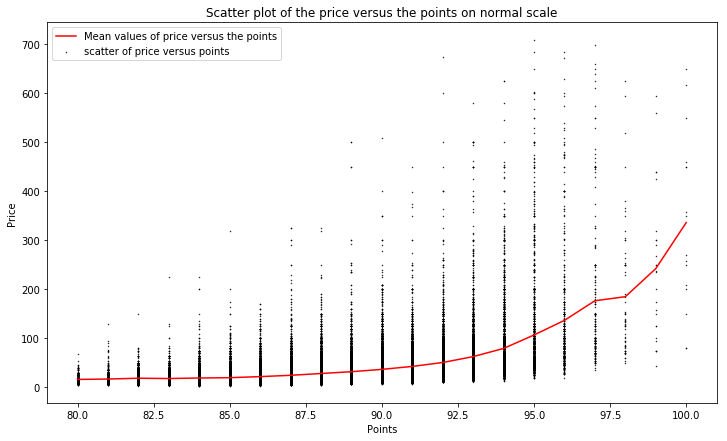

In [7]:
plt.figure(figsize=(12,7))
title = 'Scatter plot of the price versus the points on normal scale'

plt.scatter(filtered_data['points'], filtered_data['price'], 0.2, color='k', label='scatter of price versus points')
plt.plot(price_means, c='r', label='Mean values of price versus the points')

plt.xlabel('Points')
plt.ylabel('Price')
plt.legend()
plt.title(title)
plt.savefig('../figures/price_correlation/' + title)
plt.show()

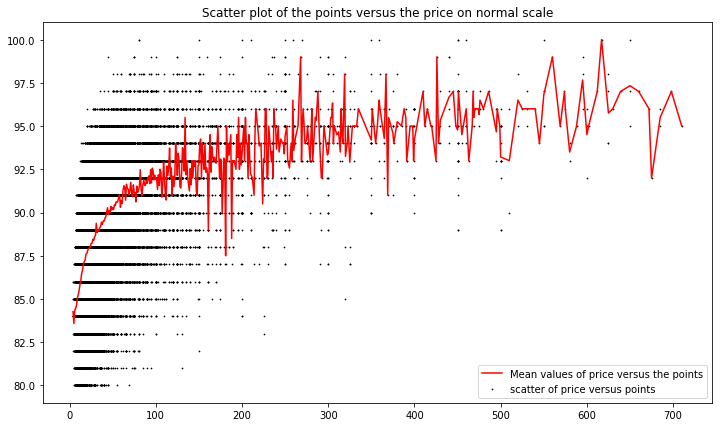

In [8]:
plt.figure(figsize=(12,7))
title = 'Scatter plot of the points versus the price on normal scale'

plt.scatter(filtered_data['price'], filtered_data['points'], 0.5, color='k', label='scatter of price versus points')
plt.plot(points_means, c='r', label='Mean values of price versus the points')

# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title(title)

plt.savefig('../figures/price_correlation/' + title)
plt.show()

The mean value of point seems to increase with the description length. But a higher amount of description length results in fluctation of the means since there is little data to work with. 

# Points versus grouped price

Group the panda dataframe by points and calculate mean and standard deviation of every group.

In [19]:
filtered_data['bin'] = pd.qcut(filtered_data['price'], 20)
point_means = filtered_data['points'].groupby(filtered_data['bin']).mean()
point_stds = filtered_data['points'].groupby(filtered_data['bin']).std()

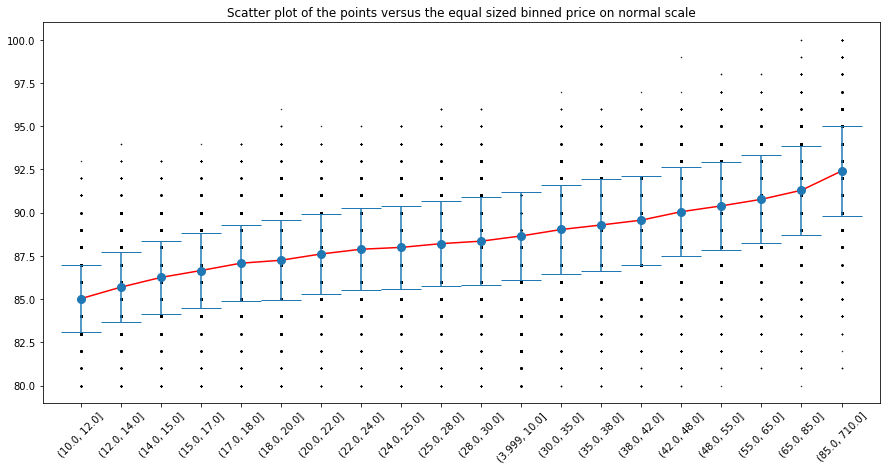

In [20]:
plt.figure(figsize=(15, 7))
title = 'Scatter plot of the points versus the equal sized binned price on normal scale'

x_tick_label = [str(x) for x in filtered_data['bin']]
xs_mean = [x for x in range(filtered_data.bin.unique().size)]

plt.scatter(x_tick_label, filtered_data['points'], 0.2, color='k')
plt.plot(xs_mean, point_means, c='r')
plt.tick_params(axis='x', rotation=45)

(_, caps, _) = plt.errorbar(
    xs_mean, point_means, yerr=point_stds, fmt='o', markersize=8, capsize=20)

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.title(title)
plt.savefig('../figures/price_correlation/' + title)
plt.show()

In [23]:
test = clean_wine_data.loc[clean_wine_data['price'] < 1000].sort_values(by=['price'])
test = test[np.abs(test.price - test.price.mean()) <= (20*test.price.std())]
value = 15

bins = np.arange(0.0, 725.0, value)
labels = [x for x in range(1, len(bins))]

filtered_data['bin'] = pd.cut(filtered_data['price'], bins=bins, labels=labels)
point_means = filtered_data['points'].groupby(filtered_data['bin']).mean()
point_stds = filtered_data['points'].groupby(filtered_data['bin']).std()
filtered_data.describe()

,points,price
count,120932.000000,120932.000000
mean,88.419401,34.969330
std,3.041650,33.579203
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,710.000000


In [12]:
from scipy.optimize import curve_fit

def func_linear(x, a, c):
    return x* a + c

def power_fit(x, a, b, c):
    return a*x**b +c

In [13]:
def plot_price_corr(title='', is_logscale=False, is_power_law_fit=False):
    plt.figure(figsize=(20, 7))

    if is_logscale:
        plt.xscale('log')
        plt.yscale('log')

    x_tick_label = [str(x) for x in filtered_data['bin']]
    xs_mean = [x for x in range(1, len(point_means) + 1)]
    xs = np.array(filtered_data['bin'].tolist())
    ys = np.array(filtered_data['points'].tolist())
    
    plt.scatter(xs, ys, 0.2, color='k', label='scatter of points versus equal binned price')
    plt.plot(xs_mean, point_means, c='r', label='mean values of points versus binned price')

    if is_power_law_fit:
        xs_log = np.log(xs)
        ys_log = np.log(ys)
        fit = np.polyfit(xs_log, ys_log, 1)
        fit_fn = np.poly1d(fit) 
        xx = np.linspace(1, 48, 48)
        plt.plot(xx, fit_fn(xx), label='fitted powerlaw')
    
    x_labels = [str(idx*value) + ' - ' + str((idx+1)*value) for idx in labels]
    xs_labels = np.arange(1, len(labels) + 1)

    if is_logscale:
        x_labels = x_labels[::2]
        xs_labels = np.arange(1, len(x_labels)*2, 2)
    
    plt.xticks(xs_labels, x_labels)
    plt.tick_params(axis='x', rotation=45)

    (_, caps, _) = plt.errorbar(
        xs_mean[0::2], point_means[0::2], yerr=point_stds[0::2], fmt='o', markersize=8, capsize=20, c='g', alpha=0.5, label='points mean with standard deviation')

    for cap in caps:
        cap.set_markeredgewidth(1)

    plt.xlabel('Equal sized price bins')
    plt.ylabel('Points')
    plt.legend()
    plt.title(title)
    path = '../figures/price_correlation/' + title
    plt.savefig(path)
    
    plt.show()

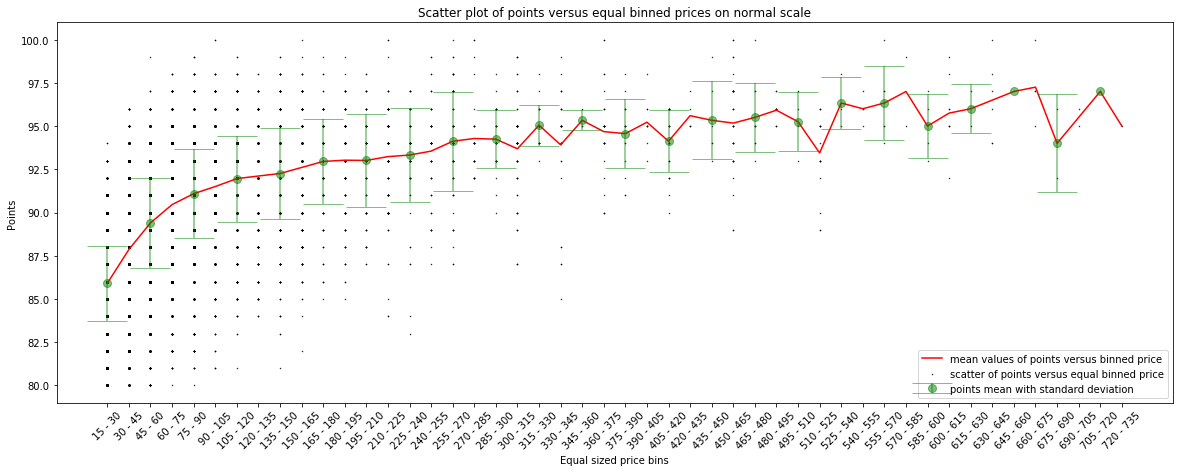

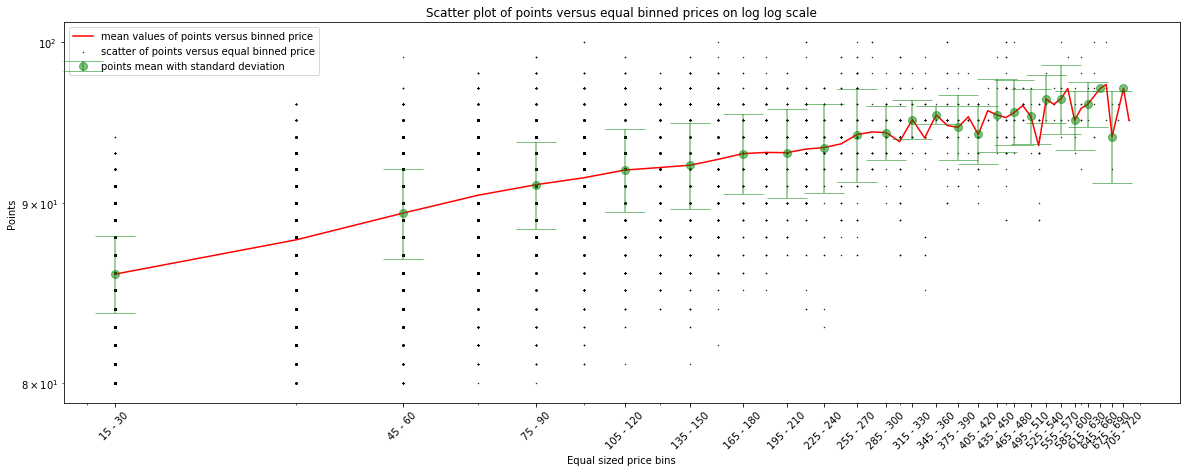

In [14]:
plot_price_corr('Scatter plot of points versus equal binned prices on normal scale', False, False)
plot_price_corr('Scatter plot of points versus equal binned prices on log log scale', True, False)

In [24]:
def plot_price_corr_flipped(title='', is_logscale=False, is_power_law_fit=False):
    plt.figure(figsize=(20, 7))
    flipped_mean = 101 - point_means
    
    if is_logscale:
        plt.xscale('log')
        plt.yscale('log')

    x_tick_label = [str(x) for x in filtered_data['bin']]
    xs_mean = [x for x in range(1, len(point_means) + 1)]
    xs = np.array(filtered_data['bin'].tolist())
    ys = 101 -np.array(filtered_data['points'].tolist())
    
    plt.scatter(xs, ys, 0.2, color='k', label='scatter of points versus equal binned price')
    plt.plot(xs_mean, flipped_mean, c='r', label='mean values of points versus binned price')

    if is_power_law_fit:
        xs_log = np.log(xs)
        ys_log = np.log(ys)
        popt, pop = curve_fit(power_fit, xs, ys, p0=[17.5, -2, 2.5], bounds=((-np.inf, -np.inf, 0), (np.inf, np.inf, np.inf)))
        xx = np.linspace(1, 48, 48)
        plt.plot(xx, power_fit(xx, *popt), label='fitted power law')
    
    x_labels = [str(idx*value) + ' - ' + str((idx+1)*value) for idx in labels]
    xs_labels = np.arange(1, len(labels) + 1)

    if is_logscale:
        x_labels = x_labels[::2]
        xs_labels = np.arange(1, len(x_labels)*2, 2)
    
    plt.xticks(xs_labels, x_labels)
    plt.tick_params(axis='x', rotation=45)

    (_, caps, _) = plt.errorbar(
        xs_mean[0::2], flipped_mean[0::2], yerr=point_stds[0::2], fmt='o', markersize=8, capsize=20, c='g', alpha=0.5, label='points mean with standard deviation')

    for cap in caps:
        cap.set_markeredgewidth(1)

    plt.xlabel('Equal sized price bins')
    plt.ylabel('Points')
    plt.legend()
    plt.title(title)
    path = '../figures/price_correlation/' + title
    plt.savefig(path)
    
    plt.show()
    return popt

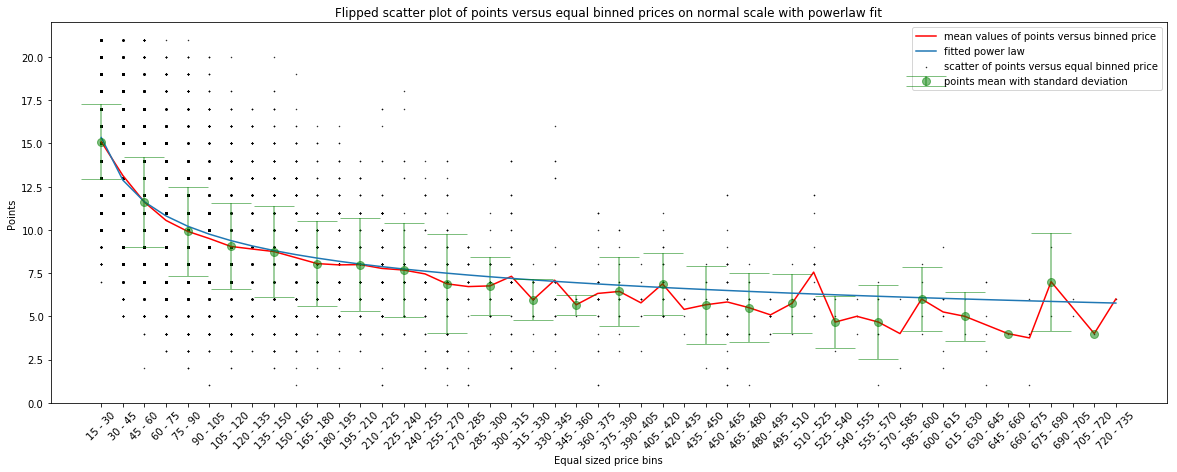

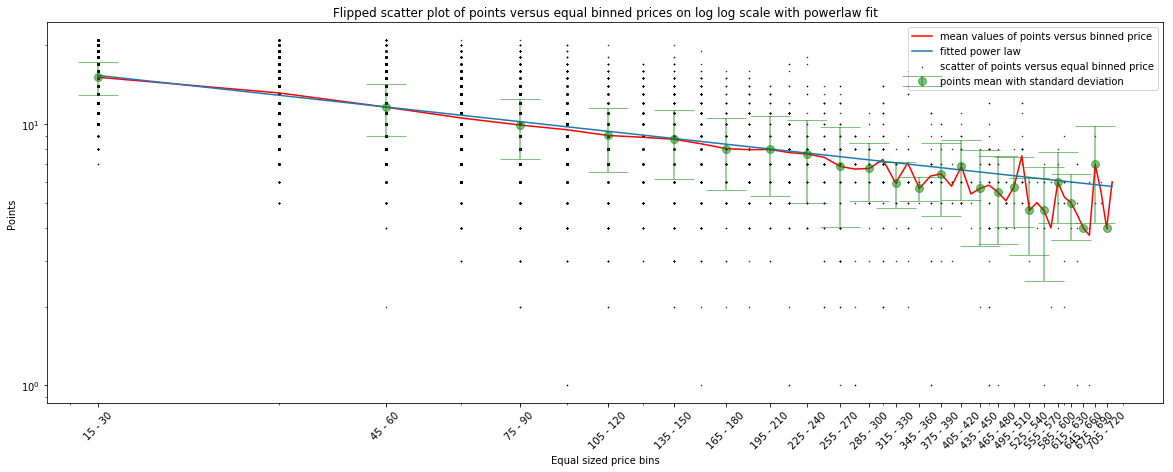

In [26]:
_ = plot_price_corr_flipped('Flipped scatter plot of points versus equal binned prices on normal scale with powerlaw fit', False, True)
params = plot_price_corr_flipped('Flipped scatter plot of points versus equal binned prices on log log scale with powerlaw fit', True, True)

In [29]:
print('Estimated parameters:\na: %f\nk: %f\nc: %f' % (params[0], params[1], params[2]))

Estimated parameters:
a: 15.333215
k: -0.252677
c: 0.000000


Power law function:
$$
y = a*x^k + c
$$

Fitted power law function(flipped)
$$
y = 15.3*x^{0.25}
$$

Score function
$$
Score = 100 - (15.3*\frac{price}{15})
$$